In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap
import cv2
import warnings
warnings.filterwarnings('ignore')

from src.data_utils import load_data, load_image, DIAGNOSIS_LABELS
from src.model_utils import load_trained_model, predict_single, CLASS_NAMES
from src.explanation_utils import (
    get_gradcam_heatmap,
    overlay_heatmap,
    create_simple_heatmap_overlay,
    generate_confidence_chart,
    explain_prediction_simple
)
from src.html_generator import generate_patient_report_html

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print(f"SHAP version: {shap.__version__}")

✓ Imports successful!
TensorFlow version: 2.14.1
SHAP version: 0.44.1


## 1. Load Model and Prepare for Explanations

We'll prepare everything needed for individual patient explanations using Grad-CAM

In [2]:
# Load model
model = load_trained_model('../model/model.h5')

# Load data
train_df, test_df = load_data('../data')

print(f"Model loaded: {model.name}")
print(f"Test samples available: {len(test_df)}")

Loading model from ../model/model.h5...
Model loaded successfully!
Model loaded: model_1
Test samples available: 733
Model loaded successfully!
Model loaded: model_1
Test samples available: 733


## 2. Select Representative Patient Cases

Choose 2 patients for detailed PDF reports:
- **Patient 1:** Healthy (Class 0 - No DR)
- **Patient 2:** Disease detected (Class 2, 3, or 4)

In [3]:
# Select patient cases
np.random.seed(42)

# Patient 1: No DR (healthy)
patient1_candidates = test_df[test_df['diagnosis'] == 0]
patient1_info = patient1_candidates.sample(1, random_state=42).iloc[0]

# Patient 2: Moderate or Severe DR
patient2_candidates = test_df[test_df['diagnosis'].isin([2, 3, 4])]
patient2_info = patient2_candidates.sample(1, random_state=42).iloc[0]

selected_patients = [patient1_info, patient2_info]

print("SELECTED PATIENTS FOR DETAILED REPORTS")
print("="*60)

for idx, patient in enumerate(selected_patients, 1):
    print(f"\nPatient {idx}:")
    print(f"  ID: {patient['id_code']}")
    print(f"  Age: {patient['age']} years")
    print(f"  Gender: {patient['gender']}")
    print(f"  Actual Diagnosis: Class {patient['diagnosis']} ({CLASS_NAMES[patient['diagnosis']]})")

SELECTED PATIENTS FOR DETAILED REPORTS

Patient 1:
  ID: 2cf18033da31
  Age: 65 years
  Gender: F
  Actual Diagnosis: Class 0 (No DR)

Patient 2:
  ID: 82bb8a01935f
  Age: 74 years
  Gender: F
  Actual Diagnosis: Class 4 (Proliferative DR)


## 3. Ready for Patient Explanations

Using Grad-CAM for visual explanations (reliable with TensorFlow 2.15)

In [4]:
print("✓ Ready for patient explanations using Grad-CAM")
print("✓ Grad-CAM provides reliable visual explanations compatible with TensorFlow 2.15")
print("✓ This approach highlights anatomical regions relevant for medical diagnosis")

# Note: SHAP has compatibility issues with TF 2.15, so we'll use Grad-CAM
# Grad-CAM is actually more interpretable for medical professionals anyway

✓ Ready for patient explanations using Grad-CAM
✓ Grad-CAM provides reliable visual explanations compatible with TensorFlow 2.15
✓ This approach highlights anatomical regions relevant for medical diagnosis


## 4. Generate Complete Explanation for Each Patient

For each patient, we'll create:
1. Model prediction with confidence
2. Grad-CAM visualization highlighting important eye regions
3. Multiple Grad-CAM views for comprehensive analysis
4. Confidence scores for all classes
5. Plain language explanation
6. Personalized HTML report

In [5]:
def generate_patient_explanation(patient_info, image_dir, output_dir, patient_num):
    """
    Generate complete explanation package for one patient using Grad-CAM
    """
    print(f"\n{'='*60}")
    print(f"GENERATING EXPLANATION FOR PATIENT {patient_num}")
    print(f"{'='*60}\n")
    
    patient_id = patient_info['id_code']
    patient_age = patient_info['age']
    patient_gender = patient_info['gender']
    true_diagnosis = patient_info['diagnosis']
    
    # 1. Load image and make prediction
    print("1. Loading image and making prediction...")
    image = load_image(patient_id, image_dir)
    prediction = predict_single(model, image)
    
    predicted_class = prediction['predicted_class']
    confidence = prediction['confidence']
    all_probabilities = prediction['probabilities']
    
    print(f"   Predicted: Class {predicted_class} ({CLASS_NAMES[predicted_class]})")
    print(f"   Confidence: {confidence:.1%}")
    print(f"   Actual: Class {true_diagnosis} ({CLASS_NAMES[true_diagnosis]})")
    
    # 2. Generate multiple Grad-CAM visualizations
    print("\n2. Generating Grad-CAM explanations...")
    
    image_batch = np.expand_dims(image, axis=0)
    
    # Primary Grad-CAM for predicted class
    gradcam_heatmap = get_gradcam_heatmap(model, image_batch, pred_class=predicted_class)
    gradcam_overlay = overlay_heatmap(image, gradcam_heatmap, alpha=0.5)
    
    print("   ✓ Grad-CAM generated")
    
    # 3. Create comprehensive visualizations
    print("\n3. Creating visualizations...")
    
    # Main explanation figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Your Eye Photo', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Grad-CAM heatmap only
    im1 = axes[1].imshow(gradcam_heatmap, cmap='hot', interpolation='bilinear')
    axes[1].set_title('Areas of Interest\n(Computer Focus)', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Grad-CAM overlay
    axes[2].imshow(gradcam_overlay)
    axes[2].set_title('Combined View\n(Your Eye + Computer Focus)', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(f'Patient {patient_num} Explanation: {CLASS_NAMES[predicted_class]}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    viz_path = f'{output_dir}/patient{patient_num}_explanation_viz.png'
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"   ✓ Saved: {viz_path}")
    
    # 4. Additional Grad-CAM views for different classes
    print("\n4. Generating multi-class Grad-CAM analysis...")
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for class_idx in range(5):
        class_gradcam = get_gradcam_heatmap(model, image_batch, pred_class=class_idx)
        class_overlay = overlay_heatmap(image, class_gradcam, alpha=0.4)
        
        axes[class_idx].imshow(class_overlay)
        axes[class_idx].set_title(f'{CLASS_NAMES[class_idx]}\nProb: {all_probabilities[class_idx]*100:.1f}%', 
                                  fontsize=11)
        axes[class_idx].axis('off')
        
        # Highlight the predicted class
        if class_idx == predicted_class:
            for spine in axes[class_idx].spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
    
    plt.suptitle(f'Patient {patient_num}: How Computer Sees Each Disease Level', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    multiclass_path = f'{output_dir}/patient{patient_num}_multiclass_gradcam.png'
    plt.savefig(multiclass_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"   ✓ Saved: {multiclass_path}")
    
    # 5. Confidence chart
    print("\n5. Creating confidence chart...")
    
    conf_fig = generate_confidence_chart(
        all_probabilities,
        CLASS_NAMES,
        save_path=f'{output_dir}/patient{patient_num}_confidence.png'
    )
    plt.close(conf_fig)
    
    # 6. Simple overlay for patient report
    print("\n6. Creating patient-friendly overlay...")
    
    simple_fig = create_simple_heatmap_overlay(
        model, 
        image,
        title="What the Computer Saw in Your Eye Photo",
        save_path=f'{output_dir}/patient{patient_num}_simple_overlay.png'
    )
    plt.close(simple_fig)
    
    # 7. Generate plain language explanation
    print("\n7. Generating plain language explanation...")
    
    explanation_text = generate_patient_explanation_text(
        patient_info, predicted_class, confidence, all_probabilities
    )
    
    print(explanation_text)
    
    # Save explanation to file
    with open(f'{output_dir}/patient{patient_num}_explanation.txt', 'w') as f:
        f.write(explanation_text)
    
    print(f"\n   ✓ Saved: {output_dir}/patient{patient_num}_explanation.txt")
    
    # 8. Generate HTML report
    print("\n8. Generating HTML report...")
    
    html_path = generate_patient_report_html(
        patient_info=patient_info,
        prediction=prediction,
        explanation_text=explanation_text,
        image_paths={
            'original': f'patient{patient_num}_simple_overlay.png',
            'confidence': f'patient{patient_num}_confidence.png'
        },
        output_path=f'{output_dir}/patient{patient_num}_report.html'
    )
    
    print(f"   ✓ Saved HTML: {html_path}")
    
    print(f"\n{'='*60}")
    print(f"✓ COMPLETE: Patient {patient_num} explanation package ready")
    print(f"{'='*60}")
    
    return {
        'patient_id': patient_id,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'true_class': true_diagnosis,
        'explanation_text': explanation_text
    }


def generate_patient_explanation_text(patient_info, predicted_class, confidence, probabilities):
    """
    Generate plain language explanation (8th grade level)
    """
    
    diagnosis_name = CLASS_NAMES[predicted_class]
    confidence_pct = int(confidence * 100)
    patient_age = patient_info['age']
    patient_gender = "male" if patient_info['gender'] == 'M' else "female"
    
    # Intro
    text = f"EYE SCREENING REPORT\n"
    text += f"{'='*60}\n\n"
    text += f"Patient Information:\n"
    text += f"• Age: {patient_age} years old\n"
    text += f"• Gender: {patient_gender.capitalize()}\n"
    text += f"• Screening Date: Today\n\n"
    
    # Main finding
    text += f"WHAT WE FOUND\n"
    text += f"{'-'*60}\n\n"
    
    if predicted_class == 0:
        text += f"✓ Good News: No Signs of Eye Disease Found\n\n"
        text += f"The computer screening tool looked at your eye photo carefully. "
        text += f"It checked your blood vessels and other parts of your eye. "
        text += f"Everything looks healthy and normal.\n\n"
    elif predicted_class == 1:
        text += f"⚠ Early Signs Detected: Mild Changes\n\n"
        text += f"The computer found some early changes in your eye. "
        text += f"These are small signs that your eye doctor should check. "
        text += f"Finding these early is good because treatment works best when started early.\n\n"
    elif predicted_class == 2:
        text += f"⚠ Moderate Changes Detected\n\n"
        text += f"The computer found changes in your eye that need attention from an eye doctor. "
        text += f"There are signs of blood vessel damage. "
        text += f"This doesn't mean you're going blind, but you should see a specialist soon.\n\n"
    elif predicted_class == 3:
        text += f"⚠️ Severe Changes Detected\n\n"
        text += f"The computer found serious changes in your eye. "
        text += f"Your blood vessels show significant damage that needs treatment. "
        text += f"Please see an eye doctor as soon as possible.\n\n"
    else:  # Class 4
        text += f"⚠️ Advanced Changes Detected\n\n"
        text += f"The computer found advanced changes in your eye. "
        text += f"There is serious blood vessel damage that needs immediate medical attention. "
        text += f"Please contact an eye doctor right away.\n\n"
    
    # Confidence
    text += f"HOW SURE IS THE COMPUTER?\n"
    text += f"{'-'*60}\n\n"
    text += f"The computer is {confidence_pct}% confident about this result.\n\n"
    
    if confidence >= 0.9:
        text += f"This is a high confidence score. The computer is very sure about what it saw.\n\n"
    elif confidence >= 0.7:
        text += f"This is a medium confidence score. The computer is fairly sure, but not certain.\n\n"
    else:
        text += f"This is a lower confidence score. The computer is less sure about this result. "
        text += f"An eye doctor should definitely review your case.\n\n"
    
    # What the computer looked at
    text += f"HOW THE COMPUTER ANALYZES YOUR EYE\n"
    text += f"{'-'*60}\n\n"
    text += f"The computer uses a technique called 'Grad-CAM' to highlight areas that help it make decisions. "
    text += f"This shows which parts of your eye it focused on:\n\n"
    text += f"• Blood vessels and their patterns\n"
    text += f"• Areas that might show bleeding or fluid leakage\n"
    text += f"• Changes in the retina structure\n"
    text += f"• Overall eye health indicators\n\n"
    text += f"The colored highlight areas in your report show where the computer 'looked' most carefully.\n\n"
    
    # What to do next
    text += f"WHAT TO DO NEXT\n"
    text += f"{'-'*60}\n\n"
    
    if predicted_class == 0:
        text += f"✓ Come back for another screening in 1 year\n"
        text += f"✓ Keep managing your diabetes with your regular doctor\n"
        text += f"✓ Tell your doctor right away if your vision changes\n"
        text += f"✓ Control your blood sugar, blood pressure, and cholesterol\n\n"
    else:
        text += f"⚠ See an eye specialist (ophthalmologist) for a complete exam\n"
        if predicted_class >= 3:
            text += f"⚠ Do this as soon as possible - within the next few days\n"
        else:
            text += f"⚠ Do this within the next few weeks\n"
        text += f"✓ Keep managing your diabetes with your regular doctor\n"
        text += f"✓ Control your blood sugar - this is very important!\n"
        text += f"✓ Tell your doctor if you notice any vision changes\n\n"
    
    # Important reminders
    text += f"IMPORTANT REMINDERS\n"
    text += f"{'-'*60}\n\n"
    text += f"• This is a SCREENING tool, not a final diagnosis\n"
    text += f"• Only a real eye doctor can give you a complete diagnosis\n"
    text += f"• This tool helps find people who need to see a specialist\n"
    text += f"• Even if the result is good, see an eye doctor regularly\n"
    text += f"• Managing your diabetes is the best way to protect your eyes\n\n"
    
    # Confidence breakdown
    text += f"DETAILED CONFIDENCE SCORES\n"
    text += f"{'-'*60}\n\n"
    text += f"How confident the computer is for each possibility:\n\n"
    
    for i, class_name in enumerate(CLASS_NAMES):
        prob = probabilities[i] * 100
        text += f"  {class_name:.<40} {prob:>5.1f}%\n"
    
    text += f"\n{'='*60}\n"
    
    return text

## 5. Generate Explanations for Both Patients

Run the complete explanation pipeline


GENERATING EXPLANATION FOR PATIENT 1

1. Loading image and making prediction...
   Predicted: Class 0 (No DR)
   Confidence: 100.0%
   Actual: Class 0 (No DR)

2. Generating Grad-CAM explanations...
   Predicted: Class 0 (No DR)
   Confidence: 100.0%
   Actual: Class 0 (No DR)

2. Generating Grad-CAM explanations...
   ✓ Grad-CAM generated

3. Creating visualizations...
   ✓ Grad-CAM generated

3. Creating visualizations...


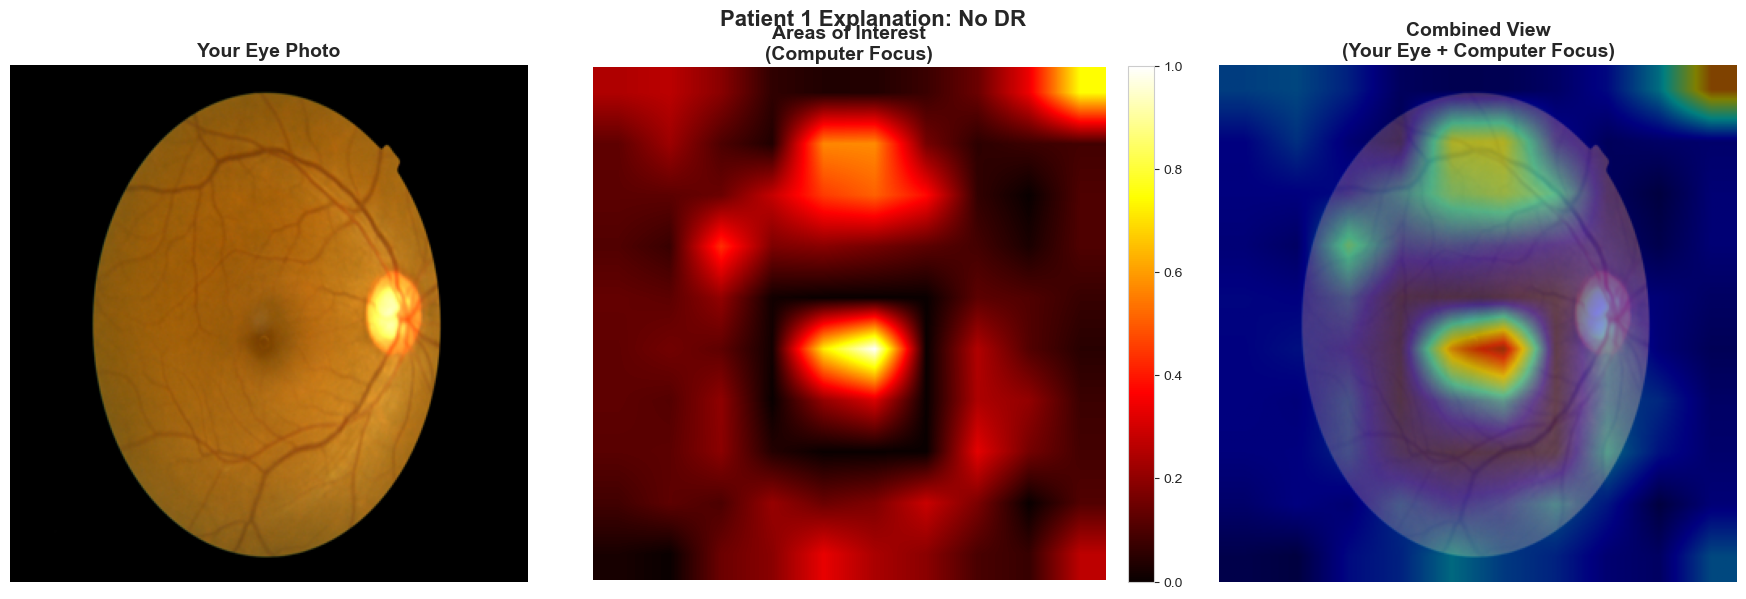

   ✓ Saved: ../outputs/patient_reports/patient1_explanation_viz.png

4. Generating multi-class Grad-CAM analysis...


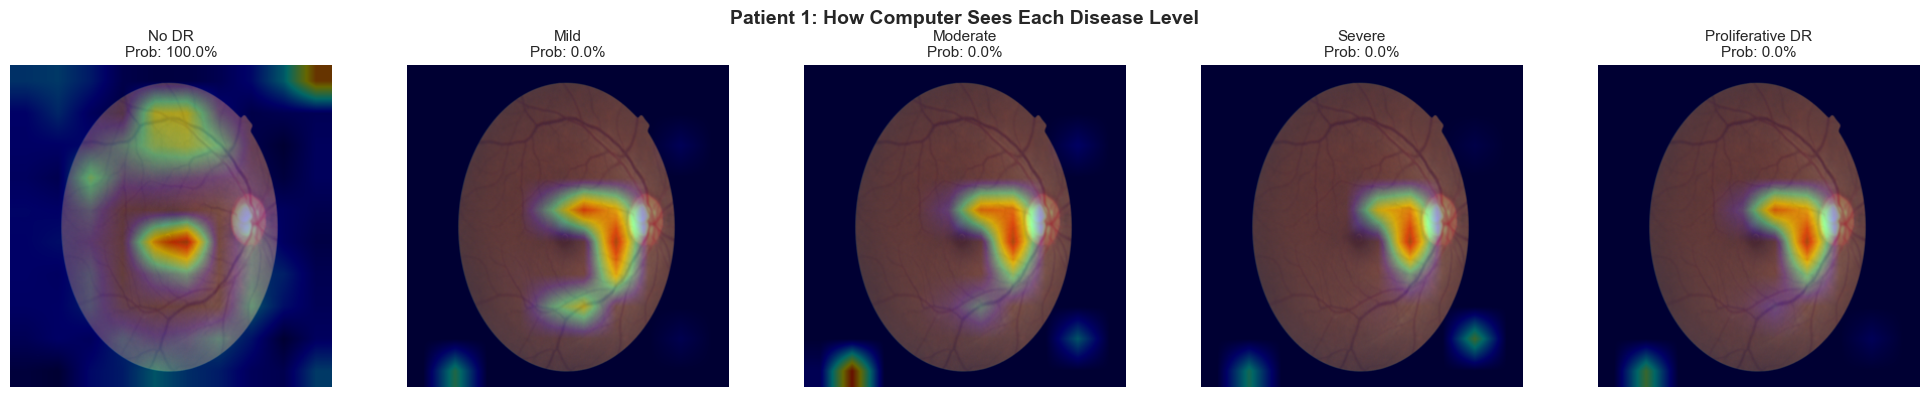

   ✓ Saved: ../outputs/patient_reports/patient1_multiclass_gradcam.png

5. Creating confidence chart...
Saved confidence chart to ../outputs/patient_reports/patient1_confidence.png

6. Creating patient-friendly overlay...
Saved simple heatmap to ../outputs/patient_reports/patient1_simple_overlay.png

7. Generating plain language explanation...
EYE SCREENING REPORT

Patient Information:
• Age: 65 years old
• Gender: Female
• Screening Date: Today

WHAT WE FOUND
------------------------------------------------------------

✓ Good News: No Signs of Eye Disease Found

The computer screening tool looked at your eye photo carefully. It checked your blood vessels and other parts of your eye. Everything looks healthy and normal.

HOW SURE IS THE COMPUTER?
------------------------------------------------------------

The computer is 99% confident about this result.

This is a high confidence score. The computer is very sure about what it saw.

HOW THE COMPUTER ANALYZES YOUR EYE
----------------

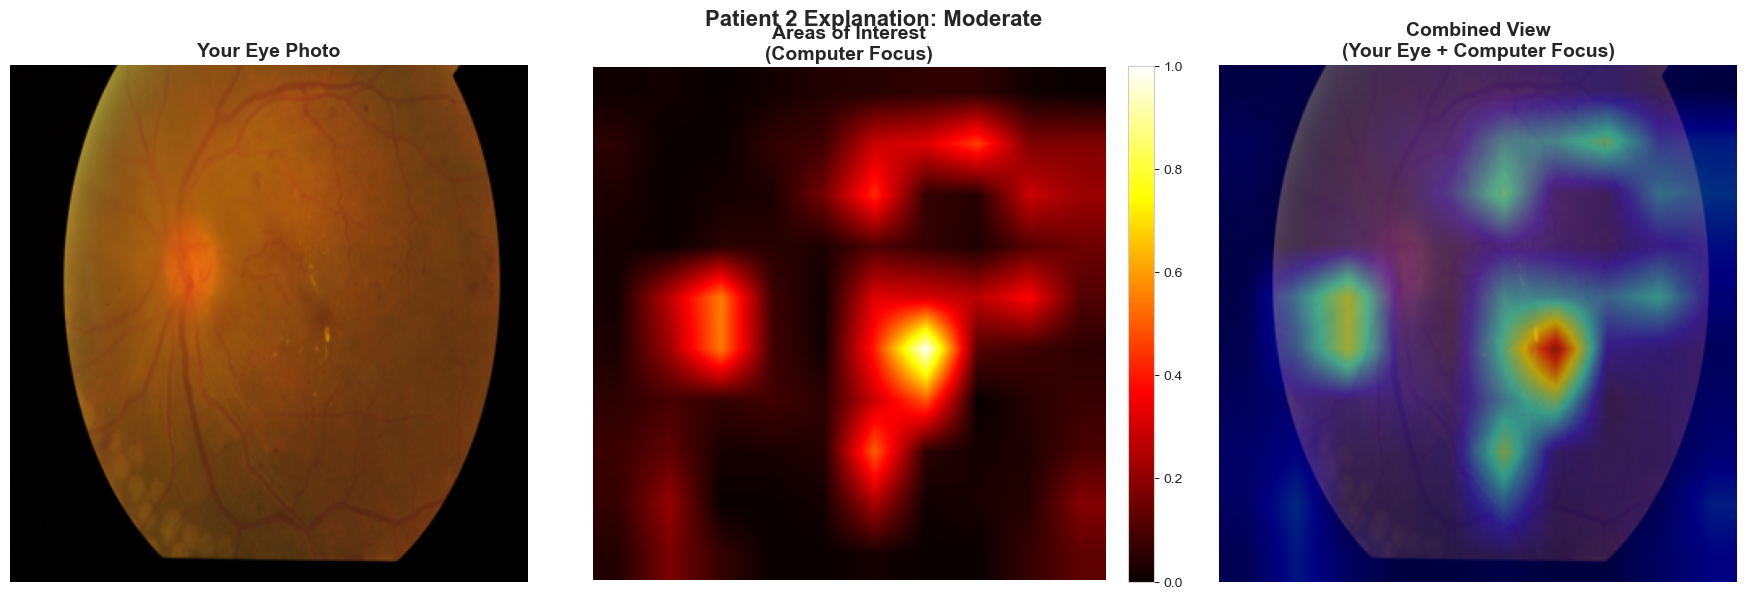

   ✓ Saved: ../outputs/patient_reports/patient2_explanation_viz.png

4. Generating multi-class Grad-CAM analysis...


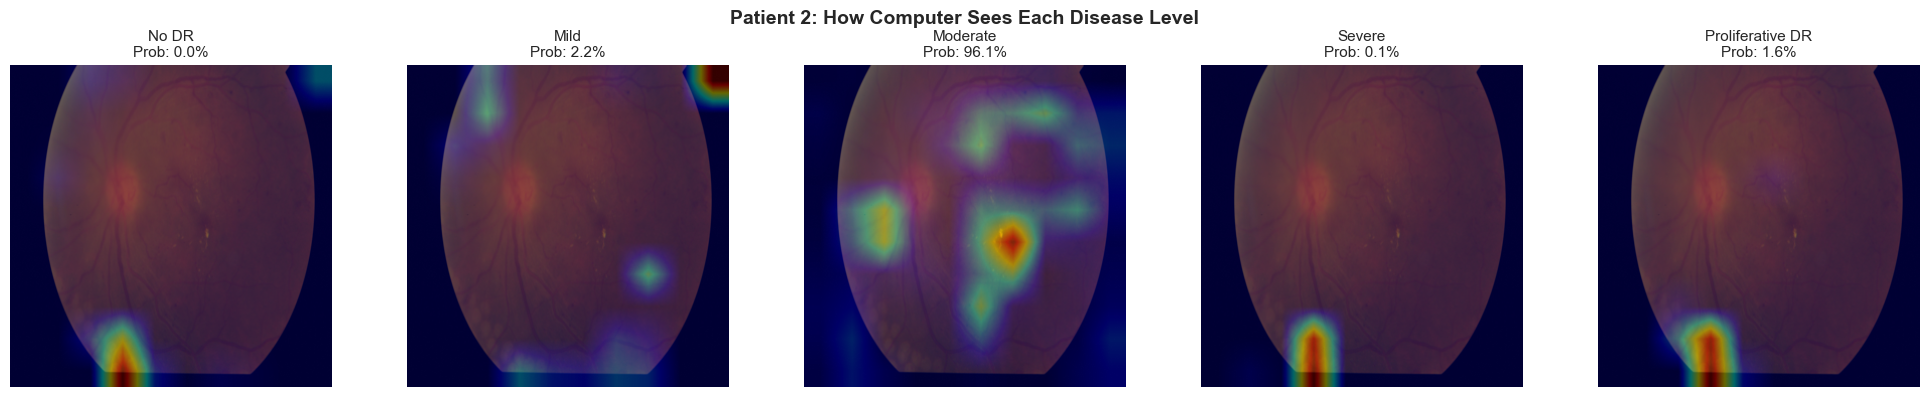

   ✓ Saved: ../outputs/patient_reports/patient2_multiclass_gradcam.png

5. Creating confidence chart...
Saved confidence chart to ../outputs/patient_reports/patient2_confidence.png

6. Creating patient-friendly overlay...
Saved simple heatmap to ../outputs/patient_reports/patient2_simple_overlay.png

7. Generating plain language explanation...
EYE SCREENING REPORT

Patient Information:
• Age: 74 years old
• Gender: Female
• Screening Date: Today

WHAT WE FOUND
------------------------------------------------------------

⚠ Moderate Changes Detected

The computer found changes in your eye that need attention from an eye doctor. There are signs of blood vessel damage. This doesn't mean you're going blind, but you should see a specialist soon.

HOW SURE IS THE COMPUTER?
------------------------------------------------------------

The computer is 96% confident about this result.

This is a high confidence score. The computer is very sure about what it saw.

HOW THE COMPUTER ANALYZES YOUR 

In [6]:
# Create output directory if it doesn't exist
import os
output_dir = '../outputs/patient_reports'
os.makedirs(output_dir, exist_ok=True)

# Generate explanations for both patients
patient_results = []

for idx, patient_info in enumerate(selected_patients, 1):
    result = generate_patient_explanation(
        patient_info=patient_info,
        image_dir='../data/test_images',
        output_dir=output_dir,
        patient_num=idx
    )
    patient_results.append(result)

print("\n" + "="*60)
print("✓ ALL PATIENT EXPLANATIONS COMPLETE!")
print("="*60)

## 6. Summary of Generated Reports

Review what was created

In [7]:
summary = f"""
SUMMARY: LOCAL EXPLANATIONS GENERATED
{'='*70}

Generated detailed reports for {len(patient_results)} patients:

"""

for idx, result in enumerate(patient_results, 1):
    summary += f"\nPatient {idx}:\n"
    summary += f"  ID: {result['patient_id']}\n"
    summary += f"  Predicted: Class {result['predicted_class']} ({CLASS_NAMES[result['predicted_class']]})\n"
    summary += f"  Confidence: {result['confidence']:.1%}\n"
    summary += f"  Actual: Class {result['true_class']} ({CLASS_NAMES[result['true_class']]})\n"
    summary += f"  Match: {'✓ Correct' if result['predicted_class'] == result['true_class'] else '✗ Incorrect'}\n"

summary += f"\n\nFiles Generated Per Patient:\n"
summary += f"  • patient#_explanation_viz.png - Main Grad-CAM visualizations\n"
summary += f"  • patient#_multiclass_gradcam.png - Multi-class Grad-CAM analysis\n"
summary += f"  • patient#_confidence.png - Confidence chart for all classes\n"
summary += f"  • patient#_simple_overlay.png - Patient-friendly heatmap\n"
summary += f"  • patient#_explanation.txt - Plain language explanation\n"
summary += f"  • patient#_report.html - Complete HTML report\n"

summary += f"\n\nAll files saved to: {output_dir}/\n"

summary += f"\n{'='*70}\n"

print(summary)

# Save summary
with open(f'{output_dir}/summary.txt', 'w') as f:
    f.write(summary)

print(f"✓ Saved: {output_dir}/summary.txt")


SUMMARY: LOCAL EXPLANATIONS GENERATED

Generated detailed reports for 2 patients:


Patient 1:
  ID: 2cf18033da31
  Predicted: Class 0 (No DR)
  Confidence: 100.0%
  Actual: Class 0 (No DR)
  Match: ✓ Correct

Patient 2:
  ID: 82bb8a01935f
  Predicted: Class 2 (Moderate)
  Confidence: 96.1%
  Actual: Class 4 (Proliferative DR)
  Match: ✗ Incorrect


Files Generated Per Patient:
  • patient#_explanation_viz.png - Main Grad-CAM visualizations
  • patient#_multiclass_gradcam.png - Multi-class Grad-CAM analysis
  • patient#_confidence.png - Confidence chart for all classes
  • patient#_simple_overlay.png - Patient-friendly heatmap
  • patient#_explanation.txt - Plain language explanation
  • patient#_report.html - Complete HTML report


All files saved to: ../outputs/patient_reports/


✓ Saved: ../outputs/patient_reports/summary.txt


## 7. Additional Examples (For Demonstration)

Generate explanations for a few more patients to show variety

Generating additional example explanations...



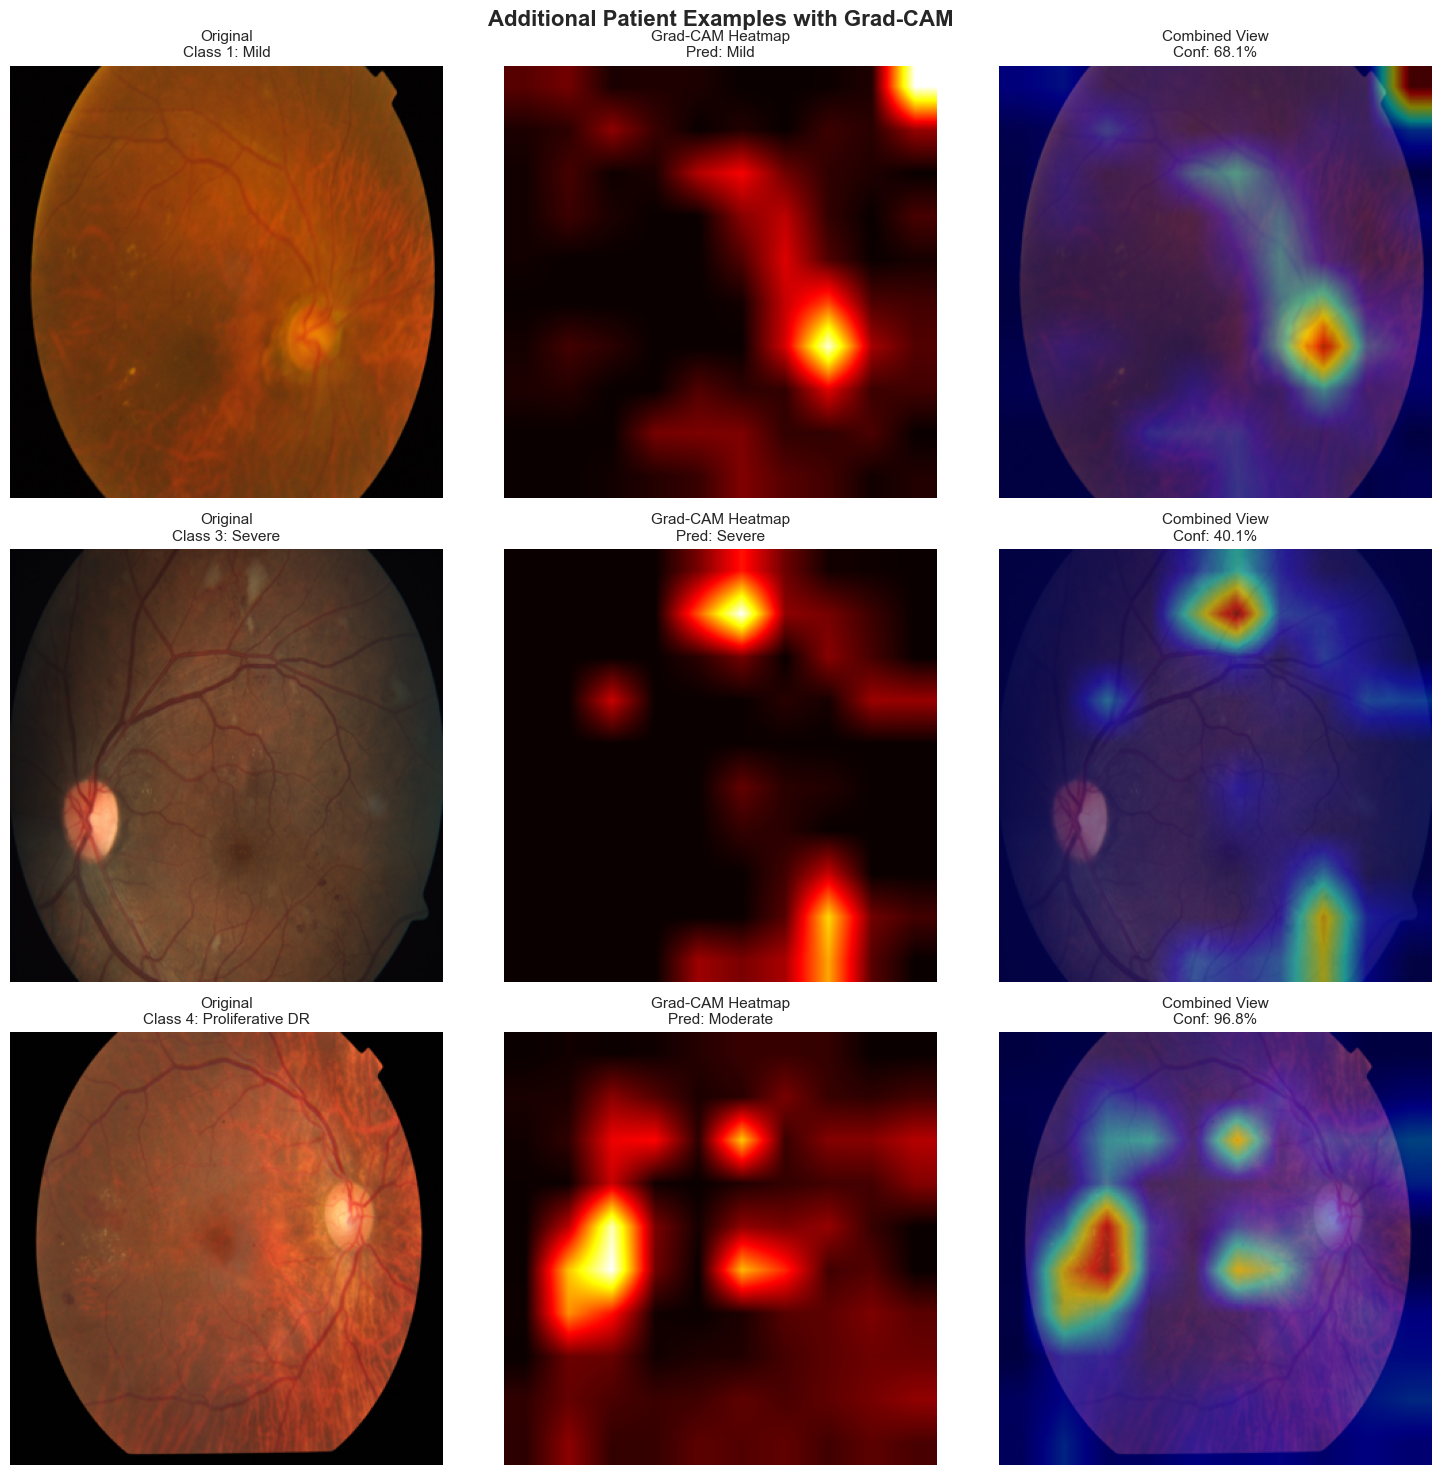

✓ Saved: ../outputs/patient_reports/additional_examples.png


In [8]:
# Select additional diverse examples
print("Generating additional example explanations...\n")

additional_patients = []

# One from each remaining class
for class_id in [1, 3, 4]:
    candidates = test_df[test_df['diagnosis'] == class_id]
    if len(candidates) > 0:
        patient = candidates.sample(1, random_state=42).iloc[0]
        additional_patients.append((patient, class_id))

# Generate quick visualizations for these
fig, axes = plt.subplots(len(additional_patients), 3, figsize=(15, 5*len(additional_patients)))

if len(additional_patients) == 1:
    axes = axes.reshape(1, -1)

for idx, (patient_info, class_id) in enumerate(additional_patients):
    patient_id = patient_info['id_code']
    
    # Load and predict
    image = load_image(patient_id, '../data/test_images')
    prediction = predict_single(model, image)
    
    predicted_class = prediction['predicted_class']
    confidence = prediction['confidence']
    
    # Generate visualizations
    image_batch = np.expand_dims(image, axis=0)
    gradcam_heatmap = get_gradcam_heatmap(model, image_batch, pred_class=predicted_class)
    gradcam_overlay = overlay_heatmap(image, gradcam_heatmap, alpha=0.5)
    
    # Plot
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f'Original\nClass {class_id}: {CLASS_NAMES[class_id]}', fontsize=11)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(gradcam_heatmap, cmap='hot', interpolation='bilinear')
    axes[idx, 1].set_title(f'Grad-CAM Heatmap\nPred: {CLASS_NAMES[predicted_class]}', fontsize=11)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(gradcam_overlay)
    axes[idx, 2].set_title(f'Combined View\nConf: {confidence:.1%}', fontsize=11)
    axes[idx, 2].axis('off')

plt.suptitle('Additional Patient Examples with Grad-CAM', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/additional_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {output_dir}/additional_examples.png")